## Visualizing the training




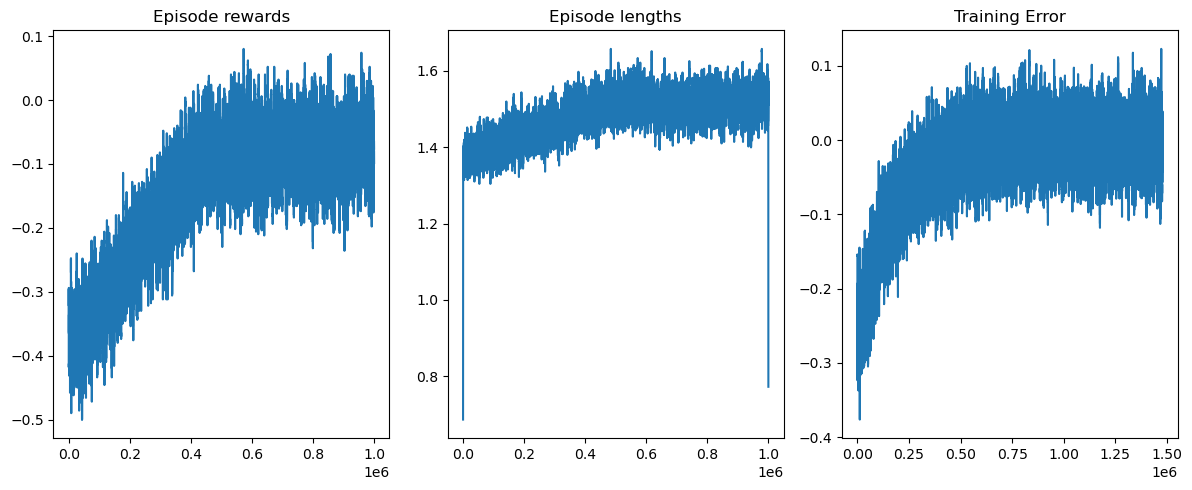

In [7]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards") #rewards over time, we see that negative feedbacks are often given
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve( # cumulative rewards of the recent n_episodes-many episodes
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length #normalize
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve( # training lengths
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show() #training error (the temporal differnce)

## Policy Visualization

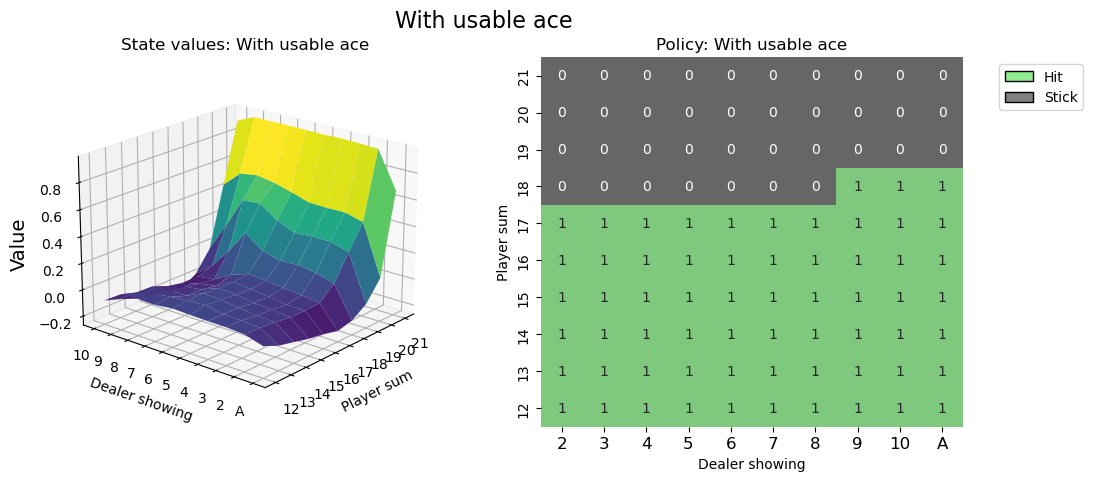

In [11]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict()
    policy = defaultdict()
    # record policy from the Q matrix
    for state, action_values in agent.q_values.items(): #q_value.items return the state-action pairs
        state_value[state] = float(np.max(action_values))
        policy[state] = int(np.argmax(action_values)) #the policy

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda state: state_value[(state[0], state[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    ) # take 1 (draw card) or not
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda state: policy[(state[0], state[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    # swapped x and y axis to fit with basic strategy
    ax2.set_ylabel("Player sum")
    ax2.set_xlabel("Dealer showing")
    ax2.set_yticklabels(range(12, 22))
    ax2.set_xticklabels(list(range(2, 11)) + ["A"], fontsize=12)
    ax2.invert_yaxis() # descending order, modified to fit with basic strategy visualization

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
def process(policy_grid):
    """
    transform the policy grid to match the original
    basic policy strategy visualization
    written by Allen Tong"""
    policy_grid=policy_grid.transpose()
    permutation = [9, 0, 1, 2, 3, 4, 5, 6, 7, 8] # move columns to where they should be
    idx = np.empty_like(permutation) #make a np array of the indices
    idx[permutation] = np.arange(len(permutation))
    policy_grid[:] = policy_grid[:, idx] #replace old np array
    return policy_grid
# print(policy_grid)
# move column of ace (A) to the rightmost
policy_grid=process(policy_grid)
# print(policy_grid)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.savefig('v1_w_ace.png')
plt.show()

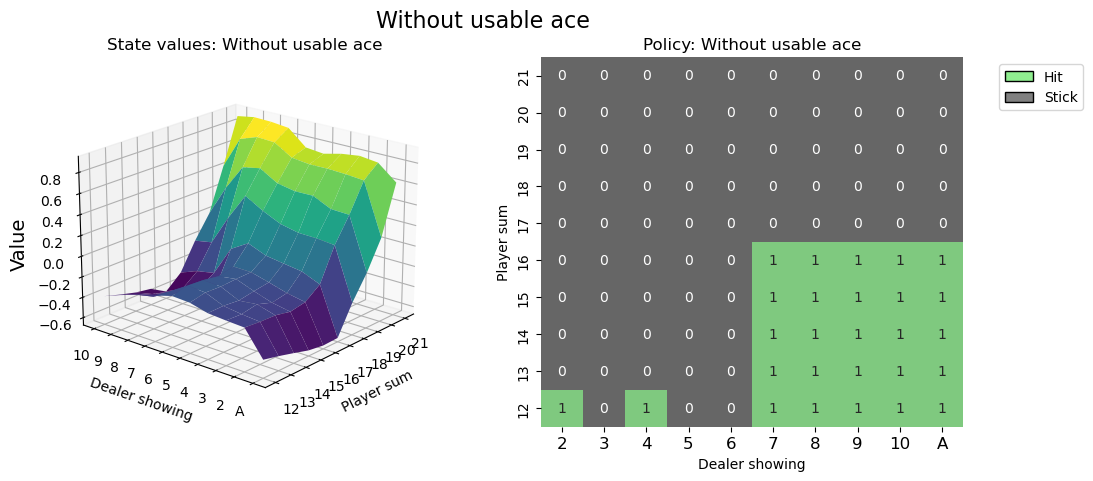

In [12]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
policy_grid=process(policy_grid)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.savefig('v1_wo_ace.png')
plt.show()

In [11]:
env.close()